# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as imbl_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [220]:
# load in the data
azdias_base = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers_base = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
# make copies
azdias = azdias_base.copy()
customers = customers_base.copy()

In [4]:
# dataframe shape, number of columns with missing values (all columns have NaNs)
azdias.shape, customers.shape, len(azdias.isnull().mean()==1) / len(azdias.columns), \
len(customers.isnull().mean()==1) / len(customers.columns)

((891221, 366), (191652, 369), 1.0, 1.0)

### Explore Missing Values

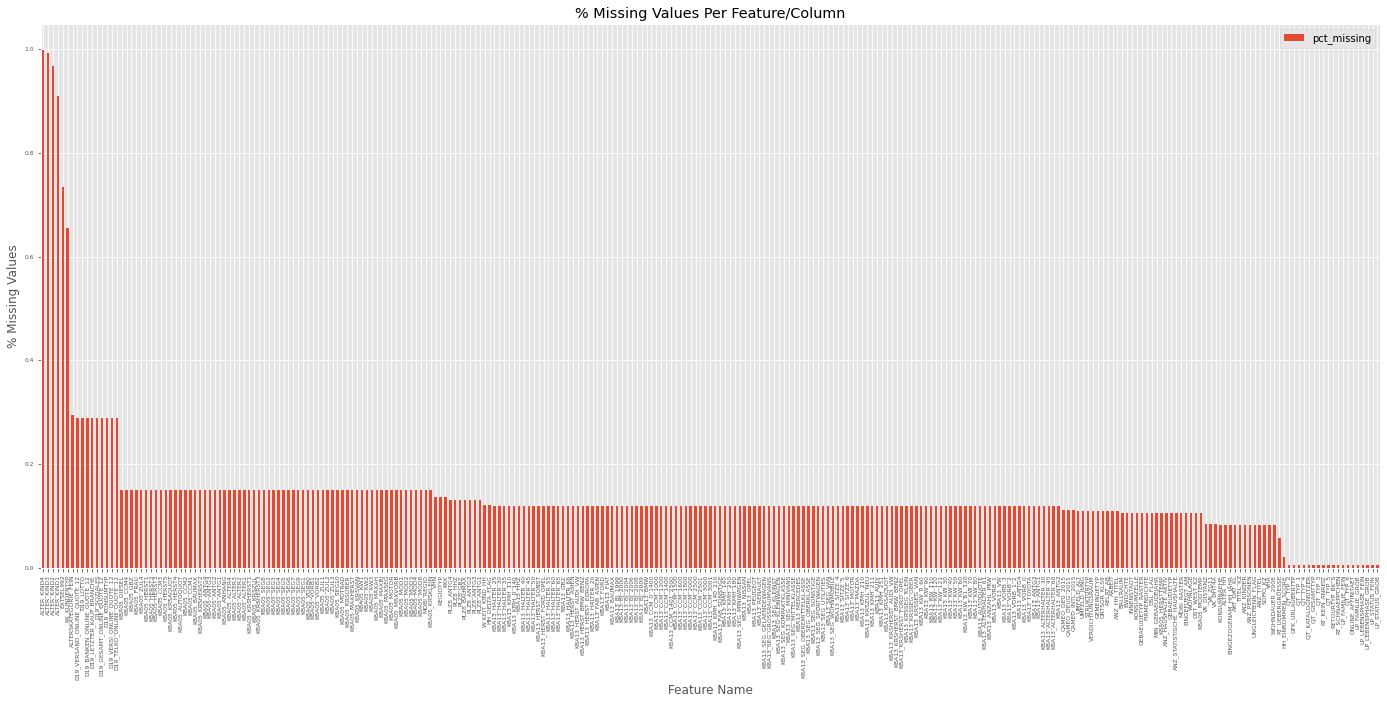

In [5]:
# azdias: for each feature (column), calculate how much data is % missing in descending order from left to right
df_missing_vals = pd.DataFrame(azdias.isnull().mean(), columns=['pct_missing']).reset_index().rename(
    columns={'index': 'column_name'}).sort_values(by=['pct_missing'], ascending=False)
df_missing_vals[df_missing_vals.pct_missing > 0].plot.bar(
    x='column_name', y='pct_missing', figsize=(24,10), fontsize=6)
plt.title("% Missing Values Per Feature/Column")
plt.xlabel("Feature Name")
plt.ylabel("% Missing Values");

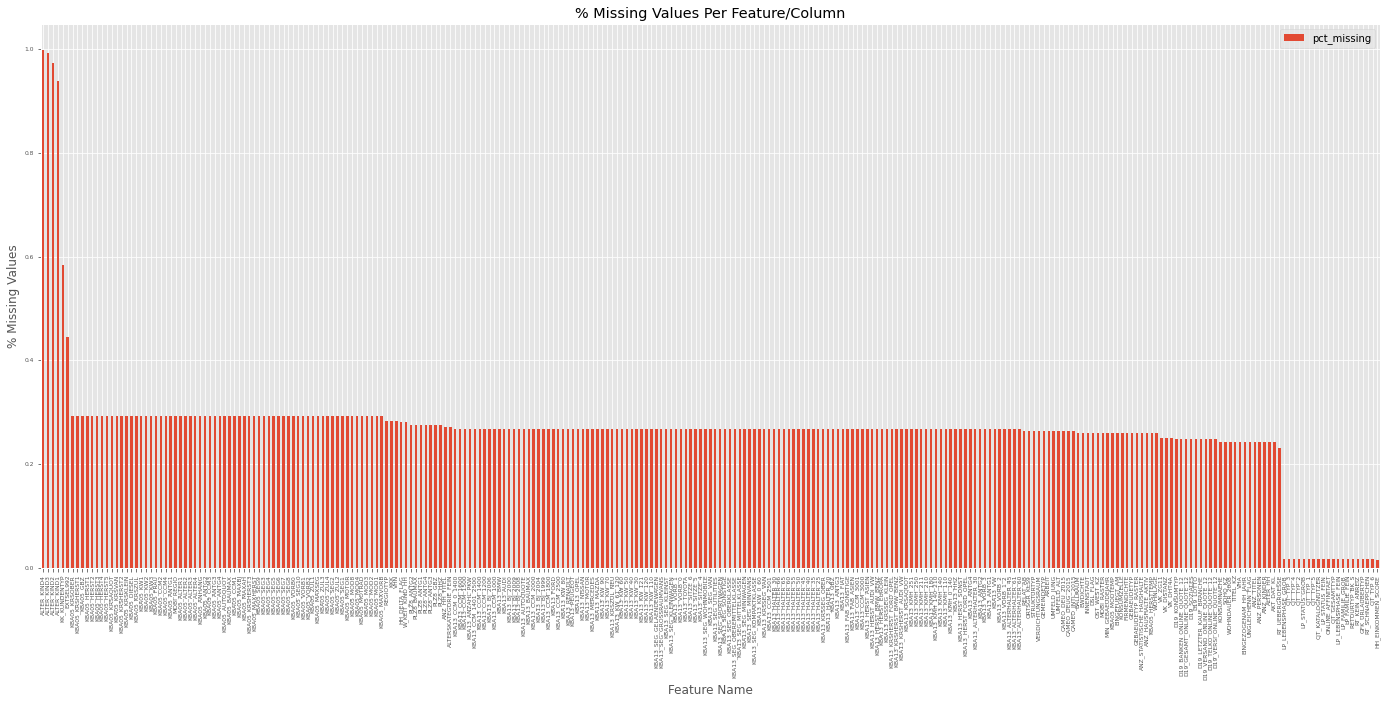

In [6]:
# customers: for each feature (column), calculate how much data is % missing in descending order 
# from left to right
df_cust_missing_vals = pd.DataFrame(customers.isnull().mean(), columns=['pct_missing']).reset_index().rename(
    columns={'index': 'column_name'}).sort_values(by=['pct_missing'], ascending=False)
df_cust_missing_vals[df_cust_missing_vals.pct_missing > 0].plot.bar(
    x='column_name', y='pct_missing', figsize=(24,10), fontsize=6)
plt.title("% Missing Values Per Feature/Column")
plt.xlabel("Feature Name")
plt.ylabel("% Missing Values");


In [7]:
# azdias: top 6 features / variables have 65% or more with missing (NaN) observations
df_missing_vals.head(10)

,column_name,pct_missing
7,ALTER_KIND4,0.998648
6,ALTER_KIND3,0.993077
5,ALTER_KIND2,0.966900
4,ALTER_KIND1,0.909048
100,EXTSEL992,0.733996
300,KK_KUNDENTYP,0.655967
8,ALTERSKATEGORIE_FEIN,0.295041
85,D19_VERSAND_ONLINE_QUOTE_12,0.288495
62,D19_LOTTO,0.288495
36,D19_BANKEN_ONLINE_QUOTE_12,0.288495


In [8]:
# customers: 5 features have 58% or higher missing data
df_cust_missing_vals.head(10)

,column_name,pct_missing
7,ALTER_KIND4,0.998769
6,ALTER_KIND3,0.993347
5,ALTER_KIND2,0.973389
4,ALTER_KIND1,0.938607
300,KK_KUNDENTYP,0.584064
100,EXTSEL992,0.444989
148,KBA05_KRSOBER,0.292092
144,KBA05_KRSHERST1,0.292092
136,KBA05_GBZ,0.292092
137,KBA05_HERST1,0.292092


In [9]:
# azdias: find the features with missing data and calculate % total 
vars_with_na = [var for var in azdias.columns if azdias[var].isnull().mean() > 0]
num_vars_with_na = len(vars_with_na)
pct_vars_with_na = len(vars_with_na) / len(azdias.columns)

print(f"Number of azdias features missing data: {num_vars_with_na}")
print(f"Percent of azdias features missing data: {pct_vars_with_na}")

Number of azdias features missing data: 273
Percent of azdias features missing data: 0.7459016393442623


In [10]:
# customers: find the features with missing data and calculate % total 
vars_with_na = [var for var in customers.columns if customers[var].isnull().mean() > 0]
num_vars_with_na = len(vars_with_na)
pct_vars_with_na = len(vars_with_na) / len(customers.columns)

print(f"Number of customers features missing data: {num_vars_with_na}")
print(f"Percent of customers features missing data: {pct_vars_with_na}")

Number of customers features missing data: 273
Percent of customers features missing data: 0.7398373983739838


### Drop Features with Missing Values around 40% or Higher, and Ambigious Features

In [12]:
# drop 6 features with over 60% of missing data
azdias_vars_with_high_missing = [var for var in azdias.columns if azdias[var].isnull().mean() > 0.6] 
print(azdias_vars_with_high_missing)
azdias.drop(columns=azdias_vars_with_high_missing, inplace=True)
print(azdias.shape)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
(891221, 360)


In [13]:
# drop redundant, unnecessary (no value add), highly skewed and ambigious features
drop_columns = ['STRUKTURTYP','GEMEINDETYP','ARBEIT','RELAT_AB','ANZ_HH_TITEL','KONSUMZELLE','FIRMENDICHTE','AGER_TYP','TITEL_KZ','GEBURTSJAHR', 'EINGEFUEGT_AM','VERDICHTUNGSRAUM','D19_LETZTER_KAUF_BRANCHE']
azdias.drop(columns=drop_columns, inplace=True)
print(azdias.shape)

(891221, 347)


In [14]:
# drop all columns found in cust_vars_with_high_missing and drop_columns variable
cust_vars_with_high_missing = [var for var in customers.columns if customers[var].isnull().mean() > 0.40] 
print(cust_vars_with_high_missing)

customers.drop(columns=cust_vars_with_high_missing + drop_columns, inplace=True)
print(customers.shape)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
(191652, 350)


### Remove User Rows with High Missing Values (>50%)

### AZDIAS

In [15]:
# count number of missing values per row/user and percent missing
azdias['num_missing'] = azdias.apply(lambda x: np.sum(x.isnull()), axis=1)
azdias['pct_missing'] = azdias.num_missing / len(azdias.columns)
print(f"Before dropping user rows: {azdias.shape}")

# dropped user rows where 50% or more of features are missing or NaN
azdias.drop(azdias[azdias.pct_missing >= 0.5].index, inplace=True)
print(f"After dropping user rows: {azdias.shape}")

Before dropping user rows: (891221, 349)
After dropping user rows: (791987, 349)


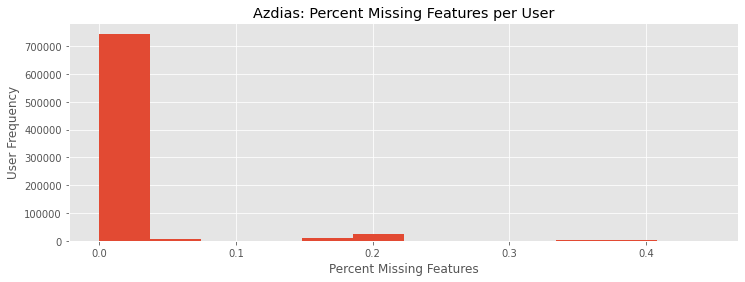

In [16]:
# for each user (row), calculate precent missing features per user; user frequency histogram
azdias.pct_missing.hist(bins=12, figsize=(12,4))
plt.title("Azdias: Percent Missing Features per User")
plt.xlabel("Percent Missing Features")
plt.ylabel("User Frequency");

### CUSTOMERS

In [17]:
# count number of missing values per row/user and percent missing
customers['num_missing'] = customers.apply(lambda x: np.sum(x.isnull()), axis=1)
customers['pct_missing'] = customers.num_missing / len(customers.columns)
print(f"Before dropping user rows: {customers.shape}")

# dropped user rows where 50% or more of features are missing or NaN
customers.drop(customers[customers.pct_missing >= 0.5].index, inplace=True)
print(f"After dropping user rows: {customers.shape}")

Before dropping user rows: (191652, 352)
After dropping user rows: (140899, 352)


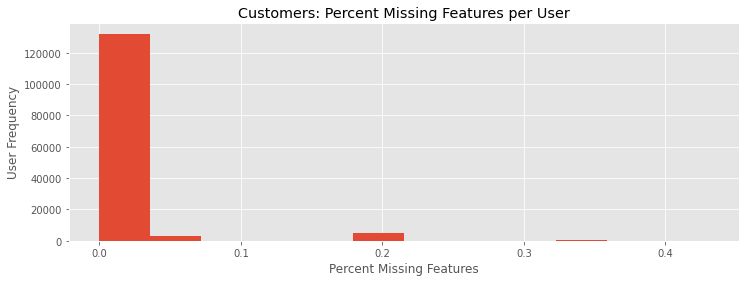

In [18]:
# for each user (row), calculate precent missing features per user; user frequency histogram
customers.pct_missing.hist(bins=12, figsize=(12,4))
plt.title("Customers: Percent Missing Features per User")
plt.xlabel("Percent Missing Features")
plt.ylabel("User Frequency");

### Quick Check-in: Snapshot of Features % Missing Values

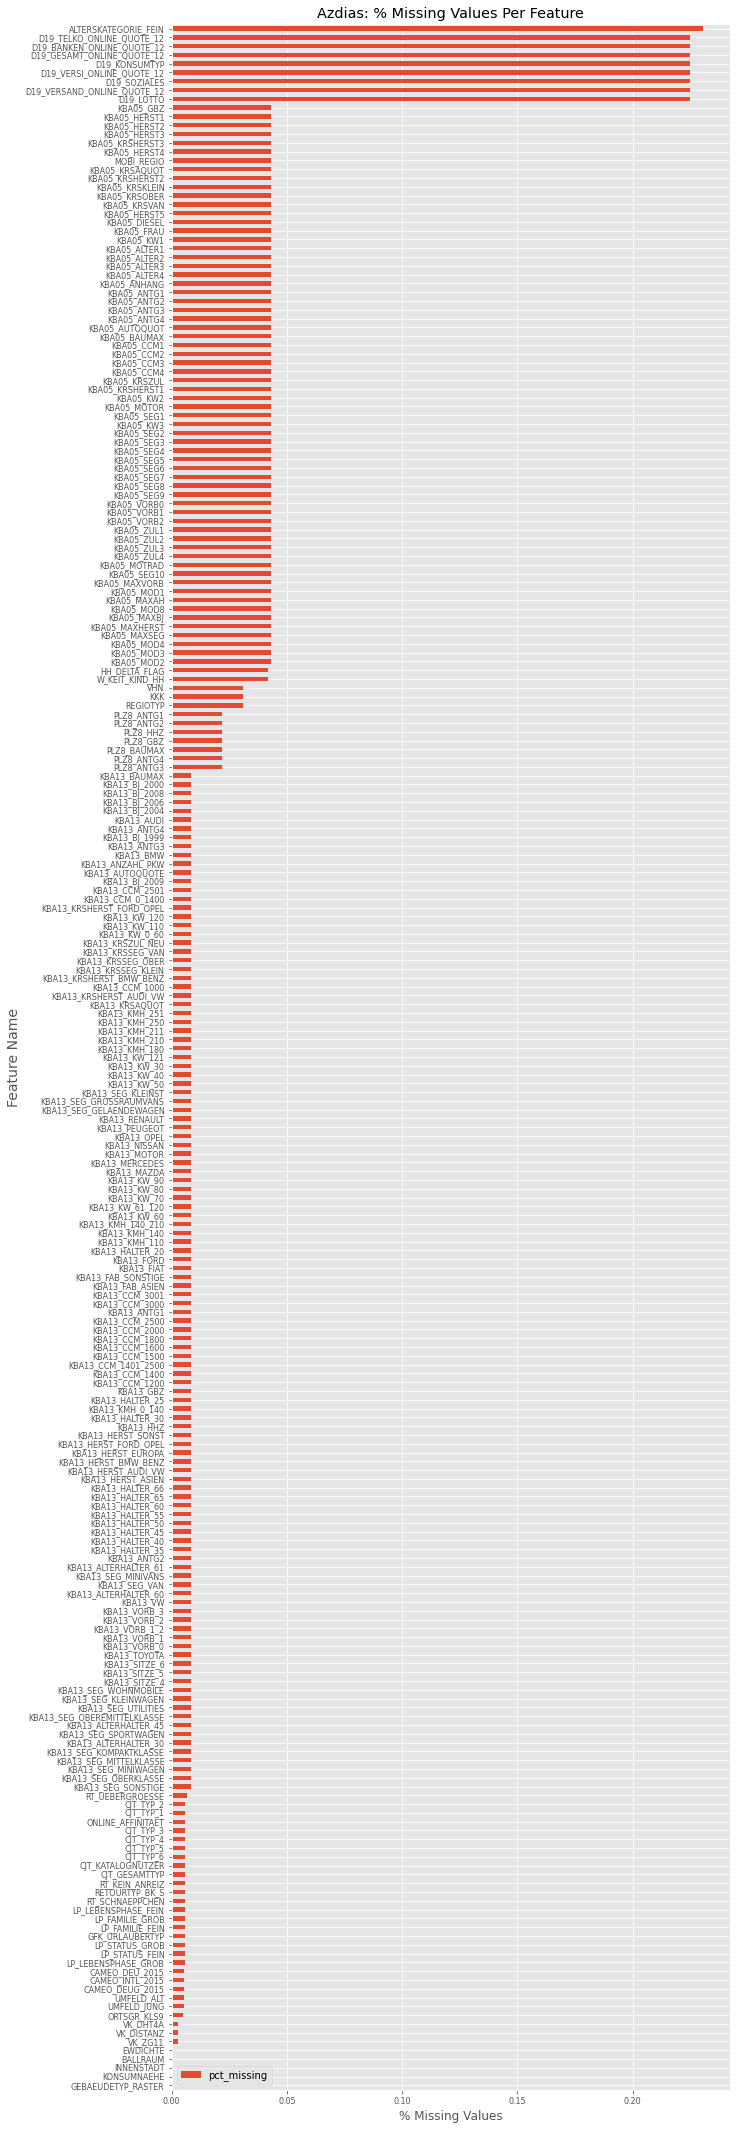

In [19]:
# for each feature (column), calculate how much data is % missing in descending order
df_missing_vals = pd.DataFrame(azdias.isnull().mean(), columns=['pct_missing']).reset_index().rename(
    columns={'index': 'column_name'}).sort_values(by=['pct_missing'], ascending=False)
df_missing_vals[df_missing_vals.pct_missing > 0].plot.barh(
    x='column_name', y='pct_missing', figsize=(10,38), fontsize=8).invert_yaxis()
plt.title("Azdias: % Missing Values Per Feature")
plt.xlabel("% Missing Values")
plt.ylabel("Feature Name", fontsize=14);

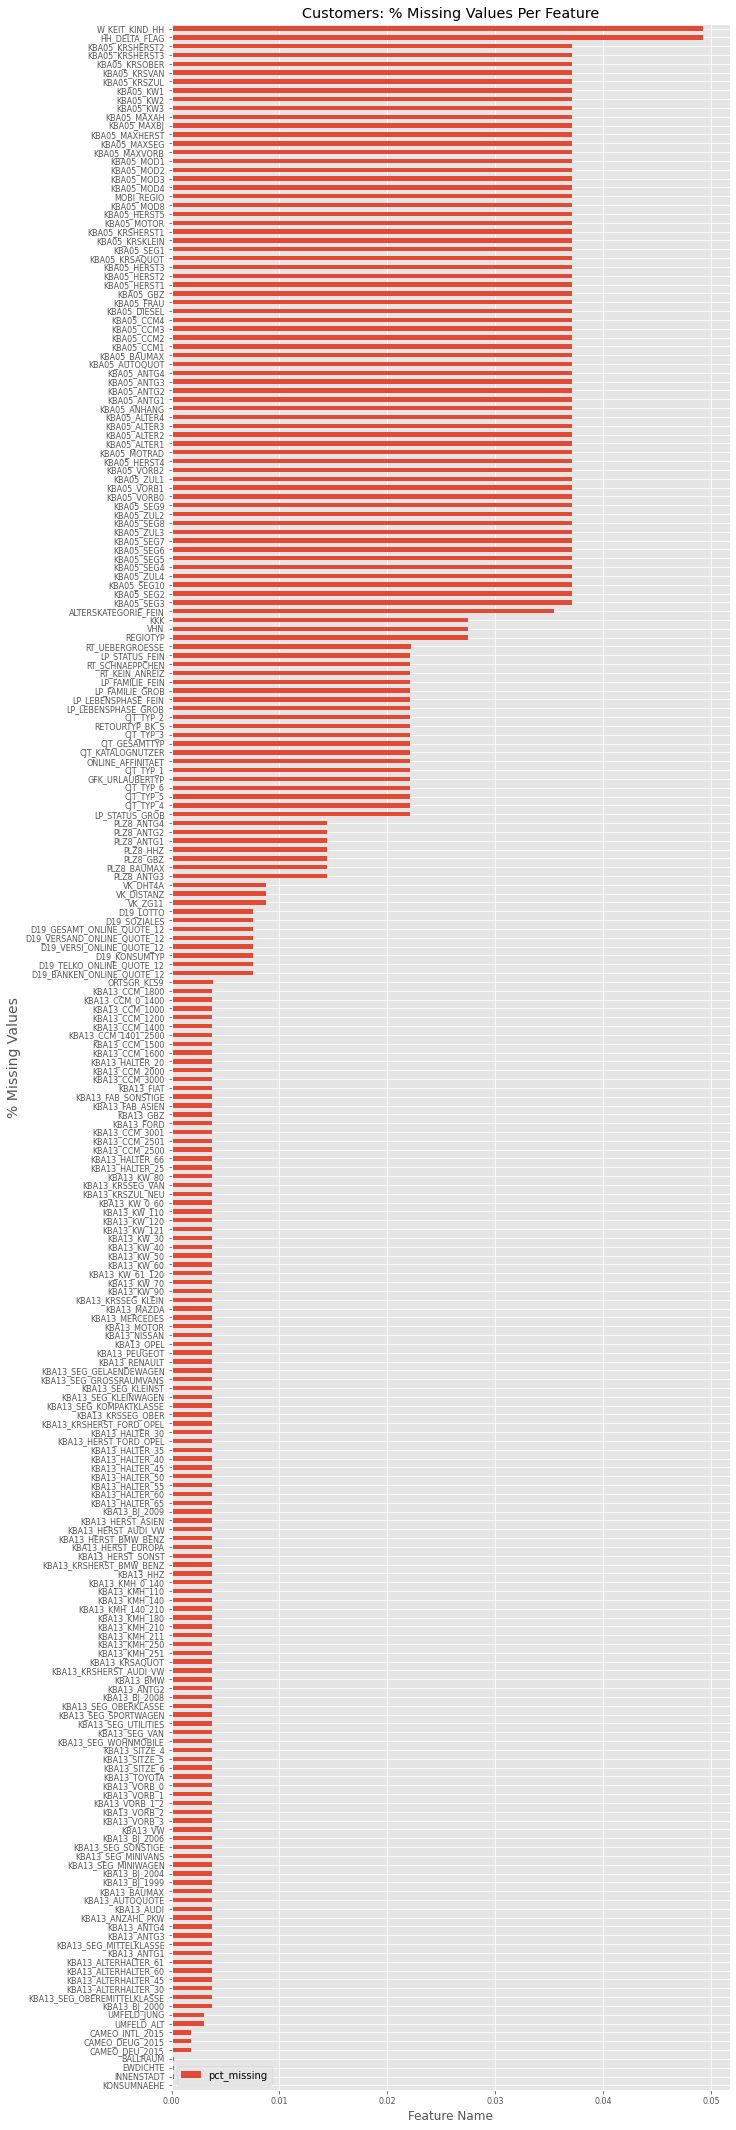

In [20]:
# for each feature (column), calculate how much data is % missing in descending order
df_cust_missing_vals = pd.DataFrame(customers.isnull().mean(), columns=['pct_missing']).reset_index().rename(
    columns={'index': 'column_name'}).sort_values(by=['pct_missing'], ascending=False)
df_cust_missing_vals[df_cust_missing_vals.pct_missing > 0].plot.barh(
    x='column_name', y='pct_missing', figsize=(10,38), fontsize=8).invert_yaxis()
plt.title("Customers: % Missing Values Per Feature")
plt.xlabel("Feature Name")
plt.ylabel("% Missing Values", fontsize=14);

### Azdias and Customers dtypes, skewness, and distribution

In [21]:
# find out whether they are numerical or categorical
vars_dtype = pd.DataFrame({'colname': azdias.columns, 'dtype': azdias.dtypes.values})
print("Azdias")
print(vars_dtype.dtype.value_counts())
print()
print("Customers")
print(pd.DataFrame({'colname': customers.columns, 'dtype': customers.dtypes.values}).dtype.value_counts())

Azdias
float64    253
int64       92
object       4
Name: dtype, dtype: int64

Customers
float64    253
int64       93
object       6
Name: dtype, dtype: int64


In [22]:
# only the categorical object features - not being float or integer or ordinal categorical variable
categorical_features = vars_dtype[vars_dtype.dtype=='object'].colname.tolist()
azdias[categorical_features].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
1,8A,8.0,51.0,W
2,4C,4.0,24.0,W
3,2A,2.0,12.0,W
4,6B,6.0,43.0,W
5,8C,8.0,54.0,W


In [23]:
cust_vars_dtypes = pd.DataFrame({'colname': customers.columns, 'dtype': customers.dtypes.values})
cat_features = cust_vars_dtypes[cust_vars_dtypes.dtype=='object'].colname.tolist()
customers[cat_features].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1.0,13.0,W,COSMETIC_AND_FOOD,MULTI_BUYER
2,5D,5.0,34.0,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4.0,24.0,W,COSMETIC,MULTI_BUYER
4,7B,7.0,41.0,W,FOOD,MULTI_BUYER
5,5D,5.0,34.0,W,COSMETIC_AND_FOOD,MULTI_BUYER


In [24]:
# identify features with missing values after preprocessing steps from above
features_with_na = pd.DataFrame(azdias.isnull().mean(), columns=['pct_missing'])
azdias_features_with_na = features_with_na[features_with_na.pct_missing > 0].index.tolist()

# group features into prefixes to create imputation strategy for mostly categorical features (ordinal & nominal)
azdias_prefixes_with_na = [var.split("_")[0] for var in azdias_features_with_na]

# create a dictionary and count number of feature occurrences for each feature prefix
prefix_dict = dict()
for prefix in azdias_prefixes_with_na:
    if prefix in prefix_dict:
        prefix_dict[prefix] += 1
    else:
        prefix_dict[prefix] = 1

# output number of prefixes, number of features, and sort prefix occurrences by descending order
print(f"Number of prefixes: {len(prefix_dict)}") 
print(f"Number of features: {len(azdias_features_with_na)}")
print()
print("Count of Prefixes:")
print(sorted(prefix_dict.items(), key=lambda x: x[1], reverse=True))

Number of prefixes: 26
Number of features: 235

Count of Prefixes:
[('KBA13', 116), ('KBA05', 63), ('CJT', 8), ('D19', 8), ('PLZ8', 7), ('LP', 6), ('CAMEO', 3), ('RT', 3), ('VK', 3), ('UMFELD', 2), ('ALTERSKATEGORIE', 1), ('BALLRAUM', 1), ('EWDICHTE', 1), ('GEBAEUDETYP', 1), ('GFK', 1), ('HH', 1), ('INNENSTADT', 1), ('KKK', 1), ('KONSUMNAEHE', 1), ('MOBI', 1), ('ONLINE', 1), ('ORTSGR', 1), ('REGIOTYP', 1), ('RETOURTYP', 1), ('VHN', 1), ('W', 1)]


In [25]:
azdias[azdias_features_with_na].shape

(791987, 235)

### Skew() Function In Pandas
* If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
* If the skewness is between -1 and 0.5 or between 0.5 and 1, the data are moderately skewed
* If the skewness is less than -1 or greater than 1, the data are highly skewed

UMFELD_ALT
Feature Skew: -0.29156774489660375


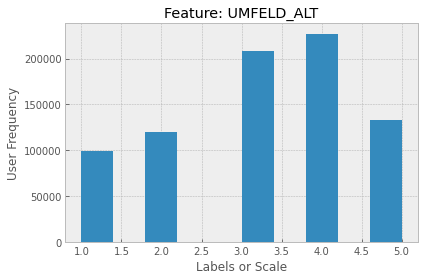


UMFELD_JUNG
Feature Skew: -1.03674258405892


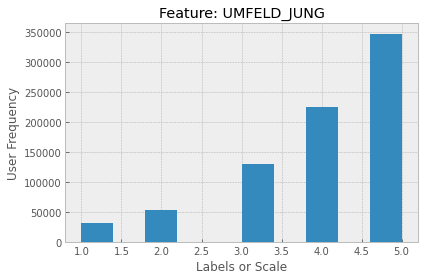

In [26]:
# Examine the distribution of features attached to each prefix and examine skew score generated by Pandas
plt.style.use('bmh')

prefix = 'UMFELD'
for var in azdias_features_with_na:
    if prefix == var.split("_")[0]:
        print(var)
        
        try:
            azdias[var].hist()
        except:
            print("Histogram not generated.")
            
        try:
            print(f"Feature Skew: {azdias[var].skew()}")
        except:
            print("Cannot calculate skew")
            
        plt.title(f"Feature: {var}")
        plt.xlabel("Labels or Scale")
        plt.ylabel("User Frequency")
        plt.tight_layout()
        plt.show()
        print()

### Imputation Strategy
**Some features do not have any descriptions in the Excel files. In those cases, I examine their histograms and identify the ambigious features as ordinal or nominal. All are categorical features except one feature.**
* ('KBA13', 116) - car related - ordinal; one feature looks continuous = KBA13_ANZAHL_PKW
* ('KBA05', 63) - car related - ordinal 
* ('D19', 9) - financial/purchase transactional activities online and offline - ordinal
* ('CJT', 8) - survey-based; customer-journey-typology info and buying channels - ordinal
* ('PLZ8', 7) - sub-postcode and household info - ordinal 
* ('LP', 6) - social status, lifestage, family type - ordinal 
* ('RT', 3) - assume ordinal
* ('CAMEO', 3) - nominal and ordinal
* ('VK', 3) - assume ordinal
* ('UMFELD', 2) - assume ordinal
* ('ALTERSKATEGORIE', 1) - age category - ordinal
* ('MOBI', 1) - nominal
* ('W', 1) - assume ordinal
* ('HH', 1) - binary 
* ('KKK', 1) - purchasing power - ordinal
* ('REGIOTYP', 1) - region type - assume nominal
* ('VHN', 1) - assume nominal
* ('RETOURTYP', 1) - return type - assume nominal
* ('ONLINE', 1) - online affinity - assume ordinal
* ('GFK', 1) - vacation habits - nominal
* ('ORTSGR', 1) - ORTSGR_KLS9; size of community - ordinal
* ('BALLRAUM', 1) - distance to the next urban center - ordinal
* ('EWDICHTE', 1) - density of inhabitants per square kilometer - ordinal
* ('INNENSTADT', 1) - distance to the city center - ordinal
* ('KONSUMNAEHE', 1) - distance from a building to PoS (Point of Sale) - ordinal
* ('GEBAEUDETYP', 1) - GEBAEUDETYP_RASTER; industrial areas - nominal

**Within this group of features, most are categorical features where the dominant feature type falls under ordinal. There are a few nominal features. In addition, there is one continuous and one binary feature.**

**Imputation Procedure**
* All categorical and binary features will be imputed by their corresponding most-frequent values.
* Continuous features will be imputed by their corresponding mean values.

In [27]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# create fit dataframe
azdias_na = pd.DataFrame(azdias.isnull().mean(), columns=['pct_missing'])
azdias_features_with_na = azdias_na[azdias_na.pct_missing > 0].index.tolist()
df_azdias_features_with_na = azdias[azdias_features_with_na]

cust_na = pd.DataFrame(customers.isnull().mean(), columns=['pct_missing'])
cust_features_with_na = cust_na[cust_na.pct_missing > 0].index.tolist()
df_customers_features_with_na = customers[cust_features_with_na]

# create categorical and continuous feature numpy arrays; sklearn transformers require numpy arrays vs lists
features_numeric = np.array(['KBA13_ANZAHL_PKW'])
az_features_categoric = np.setdiff1d(azdias_features_with_na, features_numeric)
cust_features_categoric = np.setdiff1d(cust_features_with_na, features_numeric)

# preprocessing step: different procedures on different features
az_preprocessor = ColumnTransformer(transformers=[
    ('numeric_imputer', SimpleImputer(strategy='mean'), features_numeric),
    ('categoric_imputer', SimpleImputer(strategy='most_frequent'), az_features_categoric)
])

cust_preprocessor = ColumnTransformer(transformers=[
    ('numeric_imputer', SimpleImputer(strategy='mean'), features_numeric),
    ('categoric_imputer', SimpleImputer(strategy='most_frequent'), cust_features_categoric)
])

# now we fit the preprocessor
az_preprocessor.fit(df_azdias_features_with_na)
cust_preprocessor.fit(df_customers_features_with_na)

ColumnTransformer(transformers=[('numeric_imputer', SimpleImputer(),
                                 array(['KBA13_ANZAHL_PKW'], dtype='<U16')),
                                ('categoric_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 array(['ALTERSKATEGORIE_FEIN', 'BALLRAUM', 'CAMEO_DEUG_2015',
       'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'C...
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'ORTSGR_KLS9',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4',
       'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'REGIOTYP',
       'RETOURTYP_BK_S', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',
       'RT_UEBERGROESSE', 'UMFELD_ALT', 'UMFELD_JUNG', 'VHN', 'VK_DHT4A',
       'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH'], dtype='<U27'))])

In [28]:
# impute data
azdias_imputed_only = az_preprocessor.transform(df_azdias_features_with_na)
customers_imputed_only = cust_preprocessor.transform(df_customers_features_with_na)

In [29]:
# examine the output
azdias_imputed_only = pd.DataFrame(azdias_imputed_only, 
                                   columns=list(features_numeric) + list(az_features_categoric))

customers_imputed_only = pd.DataFrame(customers_imputed_only, 
                                   columns=list(features_numeric) + list(cust_features_categoric))
print(azdias_imputed_only.shape)
print(customers_imputed_only.shape)

(791987, 235)
(140899, 234)


### Merging all imputed data into single dataframe for azdias and customers

In [30]:
def generate_full_dataframe(df_original, df_imputed):
    df_original = df_original.copy()
    df_imputed = df_imputed.copy()
    
    # azdias: combine imputed columns and the diff columns 
    diff_features_not_imputed = np.setdiff1d(df_original.columns, df_imputed.columns)
    df_features_with_no_na = df_original[diff_features_not_imputed]

    # combine the dataframe and create fully imputed / no NaN dataframe
    df_features_with_no_na.reset_index(drop=True, inplace=True)
    df_imputed.reset_index(drop=True, inplace=True)

    dfv2 = pd.concat([df_features_with_no_na, df_imputed], axis=1)
    for var in ['LNR', 'pct_missing', 'num_missing']:
        try:
            dfv2.drop(columns=var, inplace=True)
        except:
            continue

    # encode string into binary 1 or 0
    dfv2['OST_WEST_KZ'] = dfv2['OST_WEST_KZ'].apply(lambda x: 1 if x=='W' else 0)

    # encode string labels in CAMEO_DEU_2015 into numeric labels using the encoding dictionary
    cameo_deu_2015_labels = sorted(dfv2['CAMEO_DEU_2015'].unique())
    CAMEO_DEU_2015_encoding = {val: key + 1 for key, val in enumerate(cameo_deu_2015_labels)}

    # change the string labels into numeric labels
    dfv2['CAMEO_DEU_2015'] = dfv2['CAMEO_DEU_2015'].map(CAMEO_DEU_2015_encoding)

    # replace X with numeric
    dfv2['CAMEO_DEUG_2015'] = dfv2['CAMEO_DEUG_2015'].apply(lambda x: -1 if x=='X' else x)

    # replace XX with numeric
    dfv2['CAMEO_INTL_2015'] = dfv2['CAMEO_INTL_2015'].apply(lambda x: -1 if x=='XX' else x)

    # change objects into floats
    for var, dtype in dict(dfv2.dtypes).items():
        if dtype == 'O':
            dfv2[var] = dfv2[var].apply(lambda x: float(str(x).replace(" ","")))
    
    return dfv2

In [31]:
azdias_v2 = generate_full_dataframe(azdias, azdias_imputed_only)

customers.drop(columns=['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], inplace=True)
customers_v2 = generate_full_dataframe(customers, customers_imputed_only)

In [32]:
azdias_v2.shape, customers_v2.shape

((791987, 346), (140899, 346))

In [34]:
# serialize v2 dataframes and save 
pickle.dump(azdias_v2, open("serialized_objects/azdias_v2.p", "wb"))
pickle.dump(customers_v2, open("serializzed_objects/customers_v2.p", "wb"))

In [49]:
azdias_v2 = pickle.load(open("serialized_objects/azdias_v2.p", "rb"))
customers_v2 = pickle.load(open("serialized_objects/customers_v2.p", "rb"))

In [9]:
azdias_v2.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,KBA05_HERSTTEMP,KBA05_MODTEMP,KOMBIALTER,MIN_GEBAEUDEJAHR,MOBI_RASTER,NATIONALITAET_KZ,OST_WEST_KZ,PRAEGENDE_JUGENDJAHRE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,VHA,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,KBA13_ANZAHL_PKW,ALTERSKATEGORIE_FEIN,BALLRAUM,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_LOTTO,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,EWDICHTE,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,HH_DELTA_FLAG,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA1

In [11]:
azdias_v2.shape

(791987, 346)

In [10]:
customers_v2.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,KBA05_HERSTTEMP,KBA05_MODTEMP,KOMBIALTER,MIN_GEBAEUDEJAHR,MOBI_RASTER,NATIONALITAET_KZ,OST_WEST_KZ,PRAEGENDE_JUGENDJAHRE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,VHA,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,KBA13_ANZAHL_PKW,ALTERSKATEGORIE_FEIN,BALLRAUM,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_LOTTO,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,EWDICHTE,GFK_URLAUBERTYP,HH_DELTA_FLAG,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA1

In [12]:
customers_v2.shape

(140899, 346)

## Part 1: Customer Segmentation Report

Analysis: The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [36]:
# scale the azdias and customers v2 datasets
azdias_ss = StandardScaler().fit_transform(azdias_v2)
azdias_ss = pd.DataFrame(azdias_ss, columns=azdias_v2.columns).dropna()

customers_ss = StandardScaler().fit_transform(customers_v2)
customers_ss = pd.DataFrame(customers_ss, columns=customers_v2.columns).dropna()

In [37]:
# serialize ss dataframes and save 
pickle.dump(azdias_ss, open("serialized_objects/azdias_scaled.p", "wb"))
pickle.dump(customers_ss, open("serialized_objects/customers_scaled.p", "wb"))

In [46]:
# load data
azdias_ss = pickle.load(open("serialized_objects/azdias_scaled.p", "rb"))
customers_ss = pickle.load(open("serialized_objects/customers_scaled.p", "rb"))

In [47]:
# create a PCA that will retain 95% of the variance and conduct PCA
pca = PCA(n_components=0.95, whiten=True, random_state=42)
azdias_pca = pca.fit_transform(azdias_ss)

In [50]:
# show results
print('Original number of features:', azdias_v2.shape)
print('Reduced number of features:', azdias_pca.shape)

Original number of features: (791987, 346)
Reduced number of features: (791987, 212)


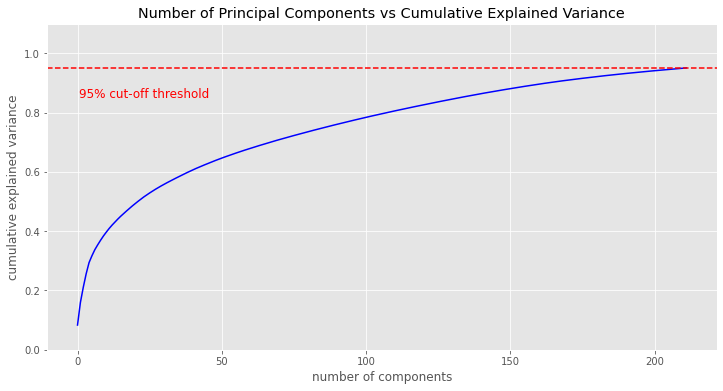

In [57]:
plt.figure(figsize=(12,6))
plt.ylim(0.0,1.1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='blue')
plt.title('Number of Principal Components vs Cumulative Explained Variance')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.axhline(y=0.95, color='r', linestyle='--')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=12)
plt.show()

Text(0, 0.5, 'explained variance')

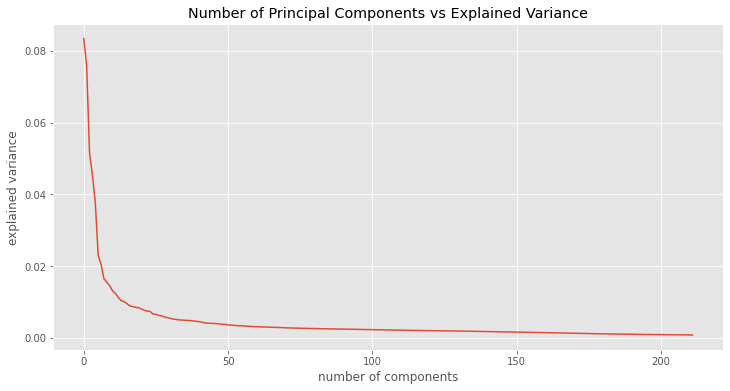

In [56]:
plt.figure(figsize=(12,6))
plt.plot(pca.explained_variance_ratio_,)
plt.title('Number of Principal Components vs Explained Variance')
plt.xlabel('number of components')
plt.ylabel('explained variance')

### What is pca.components_?
The pca.components_ attribute contains the loading scores. Positive loadings indicate a variable and a principal component are positively correlated: an increase in one results in an increase in the other. Negative loadings indicate a negative correlation. Large (either positive or negative) loadings indicate that a variable has a strong effect on that principal component.

With PCA with SVD (singular value decomposition), the principal components are scaled to 1 giving us Singlular Vector or eigenvector for each component (the loading scores are the coefficients of each variable for the first component versus the coefficients for the second component).

This also indicates which variables have the largest effect on each component. Loadings can range from -1 to 1. Loadings close to -1 or 1 indicate that the variable strongly influences the component. Loadings close to 0 indicate that the variable has a weak influence on the component. Evaluating the loadings can also help you characterize each component in terms of the variables.

In [58]:
pca.components_.shape

(212, 346)

In [59]:
n = pca.components_.shape[0]
azdias_pca_weights = pd.DataFrame(pca.components_, columns=azdias_ss.columns, index=[
    'PC' + str(i) for i in range(1, n+1)])
azdias_pca_weights.head(10)

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,KBA05_HERSTTEMP,KBA05_MODTEMP,KOMBIALTER,MIN_GEBAEUDEJAHR,MOBI_RASTER,NATIONALITAET_KZ,OST_WEST_KZ,PRAEGENDE_JUGENDJAHRE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,VHA,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,KBA13_ANZAHL_PKW,ALTERSKATEGORIE_FEIN,BALLRAUM,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_LOTTO,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,EWDICHTE,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,HH_DELTA_FLAG,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA1

<< PC1 Explained Variance: 8.3459% >>


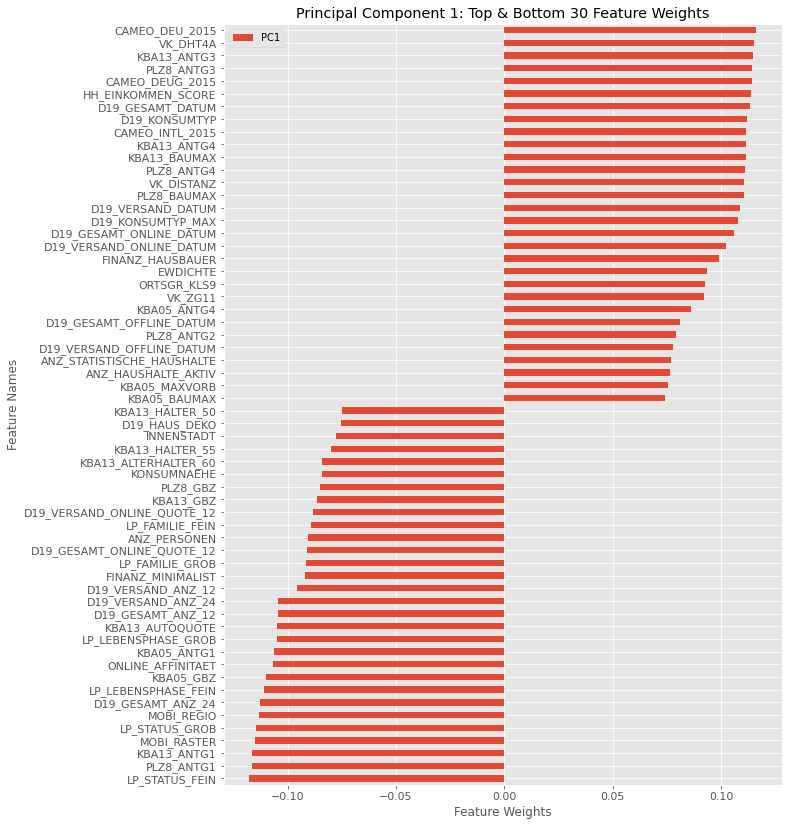

In [60]:
n = pca.components_.shape[0]
azdias_pca_weights = pd.DataFrame(pca.components_, columns=azdias_ss.columns, index=[
    'PC' + str(i) for i in range(1, n+1)])

# PC1 explained variance
print(f"<< PC1 Explained Variance: {str(round(pca.explained_variance_ratio_[0].sum()*100,4)) + '%'} >>")

# show top 30 and bottom 30 feature weights for principal-component-1
pd.concat([azdias_pca_weights[azdias_pca_weights.index=='PC1'].T.sort_values(
    by=['PC1'], ascending=False).iloc[:30],
           azdias_pca_weights[azdias_pca_weights.index=='PC1'].T.sort_values(
    by=['PC1'], ascending=False).iloc[-30:]], axis=0).plot.barh(figsize=(10,14), fontsize=11).invert_yaxis()

plt.title("Principal Component 1: Top & Bottom 30 Feature Weights")
plt.xlabel("Feature Weights")
plt.ylabel("Feature Names");

<< PC1 Explained Variance: 7.595% >>


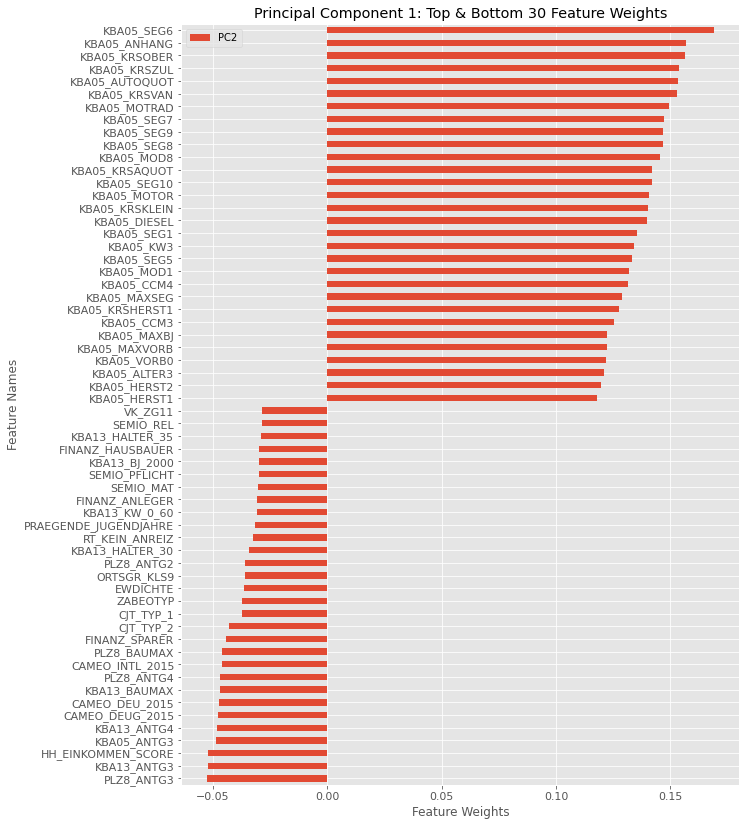

In [61]:
# PC2 explained variance
print(f"<< PC1 Explained Variance: {str(round(pca.explained_variance_ratio_[1].sum()*100,4)) + '%'} >>")

# show top 30 and bottom 30 feature weights for principal-component-2
pd.concat([azdias_pca_weights[azdias_pca_weights.index=='PC2'].T.sort_values(
    by=['PC2'], ascending=False).iloc[:30],
           azdias_pca_weights[azdias_pca_weights.index=='PC2'].T.sort_values(
    by=['PC2'], ascending=False).iloc[-30:]], axis=0).plot.barh(figsize=(10,14), fontsize=11).invert_yaxis()

plt.title("Principal Component 2: Top & Bottom 30 Feature Weights")
plt.xlabel("Feature Weights")
plt.ylabel("Feature Names");

In [62]:
%%time

df_azdias_pca = pd.DataFrame(azdias_pca)
n = int(len(df_azdias_pca) * 0.1)
scores = []

for i in range(1, 41):
    km = KMeans(n_clusters=i, init='k-means++', random_state=42)
    km.fit(df_azdias_pca.sample(n))
    scores.append(km.inertia_)

CPU times: user 56min 54s, sys: 5min 40s, total: 1h 2min 34s
Wall time: 8min 56s


Text(0, 0.5, 'Average Within-Cluster Distances')

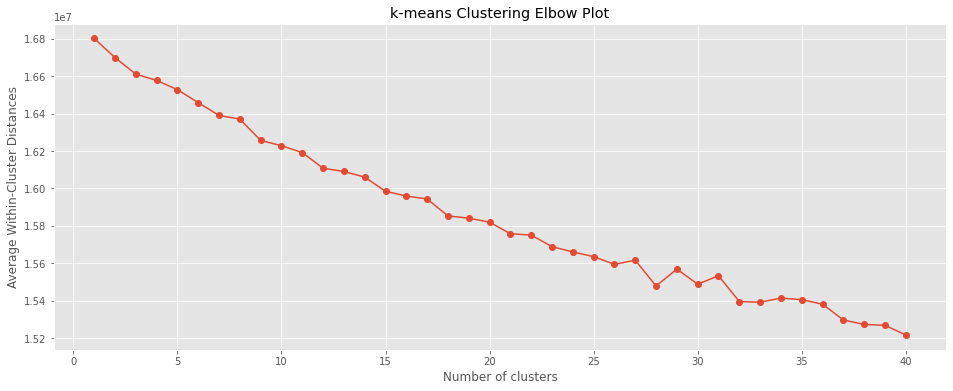

In [63]:
centers = np.linspace(1,40,40)
plt.figure(figsize=(16, 6))
plt.plot(centers, scores, '-o')
plt.title('k-means Clustering Elbow Plot')
plt.xlabel("Number of clusters")
plt.ylabel("Average Within-Cluster Distances")

In [77]:
# 15 clusters
n_clusters = 15
km = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
km.fit(azdias_pca)
azdias_km = pd.DataFrame(km.predict(azdias_pca), columns=['cluster'])

In [78]:
# lowest SSE value
print(km.inertia_)
# final locations of the centroid
print(km.cluster_centers_)
# number of iterations required to converge
print(km.n_iter_)

160291813.99083143
[[-1.01088257  0.17005907  0.91899749 ...  0.02382917 -0.00924703
  -0.03443246]
 [ 0.78430521 -0.13063466 -0.33963402 ... -0.23335435 -0.173418
   0.93787028]
 [ 1.19359524 -0.48731336  0.4523656  ...  0.08915549 -0.02581202
  -0.06754159]
 ...
 [ 0.98422714  0.33211345  0.00860504 ... -0.00990945 -0.00134328
  -0.04883694]
 [ 0.33652302 -0.31160514 -0.02999002 ... -0.02773167 -0.03311307
  -0.08606035]
 [-0.19605377  0.21760785 -0.32938364 ...  0.02783184  0.00882051
  -0.01881548]]
44


In [80]:
customers_pca = pca.transform(customers_ss)
customers_km = pd.DataFrame(km.predict(customers_pca), columns=['cluster'])

In [81]:
pickle.dump(customers_pca, open("serialized_objects/customers_pca.p", "wb"))
pickle.dump(customers_km, open("serialized_objects/customers_km.p", "wb"))

In [82]:
# load pickled files
azdias_pca = pickle.load(open("serialized_objects/azdias_pca.p", "rb"))
azdias_km = pickle.load(open("serialized_objects/azdias_km.p", "rb"))

customers_pca = pickle.load(open("serialized_objects/customers_pca.p", "rb"))
customers_km = pickle.load(open("serialized_objects/customers_km.p", "rb"))

In [83]:
# (791987, 212)
azdias_pca

array([[ 0.77679067, -0.58162895,  0.45071201, ...,  0.03131369,
         1.46142628,  0.76776023],
       [ 0.00372481, -0.06351443, -0.54562878, ...,  0.5851831 ,
         0.20489443, -1.21956007],
       [-0.41953194,  0.490869  , -1.568292  , ...,  1.42433011,
        -1.82301411, -0.49001891],
       ...,
       [-0.64680993,  0.03604558,  0.5290862 , ...,  1.00289316,
        -1.56507508,  0.36956595],
       [ 1.06705837, -1.06145791,  1.13676053, ..., -0.32148978,
        -0.46915383,  1.27093045],
       [ 0.22297502, -0.09144154, -1.52580142, ...,  0.52761099,
        -0.19022621,  0.67923257]])

In [215]:
azdias_km.head()

,cluster
0,10
1,7
2,11
3,9
4,7


In [90]:
azdias_clusters = pd.DataFrame(azdias_km.cluster.value_counts()).rename(
    columns={'cluster':'azdias_cluster_size'}).sort_index()

customers_clusters = pd.DataFrame(customers_km.cluster.value_counts()).rename(
    columns={'cluster':'cust_cluster_size'}).sort_index()

km_clusters = pd.concat([azdias_clusters, customers_clusters], axis=1).fillna(0)
km_clusters

,azdias_cluster_size,cust_cluster_size
0,13814,3992.0
1,19013,1376.0
2,50154,6267.0
3,29695,6112.0
4,45636,9908.0
5,32934,11178.0
6,39722,11931.0
7,145595,19263.0
8,57734,8923.0
9,40655,10960.0


In [92]:
km_clusters['azdias_cluster_pct'] = km_clusters['azdias_cluster_size'] / km_clusters['azdias_cluster_size'].sum()
km_clusters['cust_cluster_pct'] = km_clusters['cust_cluster_size'] / km_clusters['cust_cluster_size'].sum()
km_clusters.index = range(1,16)
km_clusters

,azdias_cluster_size,cust_cluster_size,azdias_cluster_pct,cust_cluster_pct
1,13814,3992.0,0.017442,0.028332
2,19013,1376.0,0.024007,0.009766
3,50154,6267.0,0.063327,0.044479
4,29695,6112.0,0.037494,0.043379
5,45636,9908.0,0.057622,0.070320
6,32934,11178.0,0.041584,0.079333
7,39722,11931.0,0.050155,0.084678
8,145595,19263.0,0.183835,0.136715
9,57734,8923.0,0.072898,0.063329
10,40655,10960.0,0.051333,0.077786


In [129]:
# 8 clusters where the customers are larger than general population 
km_clusters['diff'] = km_clusters.cust_cluster_pct - km_clusters.azdias_cluster_pct
km_clusters.sort_values(by=['diff'], ascending=False).head(7)

,azdias_cluster_size,cust_cluster_size,azdias_cluster_pct,cust_cluster_pct,diff
12,144425,37089.0,0.182358,0.263231,0.080873
6,32934,11178.0,0.041584,0.079333,0.037749
7,39722,11931.0,0.050155,0.084678,0.034523
10,40655,10960.0,0.051333,0.077786,0.026453
5,45636,9908.0,0.057622,0.070320,0.012698
1,13814,3992.0,0.017442,0.028332,0.010890
4,29695,6112.0,0.037494,0.043379,0.005884


**The above data table and below bar chart illustrate the relevant kmeans clusters. The above table shows seven clusters where the customer % population is greater than the same population clusters. Clusters 12, 6, and 7 are the standouts.**

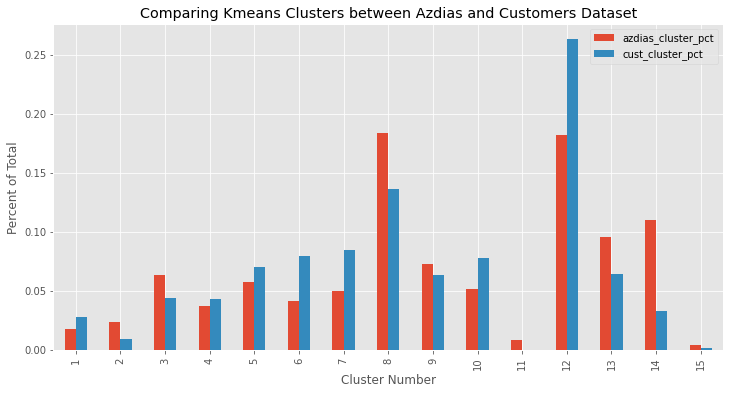

In [94]:
km_clusters.plot.bar(y=['azdias_cluster_pct','cust_cluster_pct'], figsize=(12,6))
plt.title("Comparing Kmeans Clusters between Azdias and Customers Dataset")
plt.xlabel("Cluster Number")
plt.ylabel("Percent of Total")
plt.show()

In [137]:
# pca object is from the fitted PCA from above; code: pca = PCA(n_components=0.95, whiten=True, random_state=42)
def pca_inv_transform_plot(df_original, kmeans_fitted, n_cluster):
    # map kmean's nth cluster's centers to original features using pca.inverse_transform 
    df_pca_inv = pd.DataFrame.from_dict(
        dict(zip(df_original.columns, pca.inverse_transform(
            kmeans_fitted.cluster_centers_[n_cluster]))), orient='index').rename(
                columns={0: 'feat_vals'}).sort_values('feat_vals', ascending=False)
    # convert pca.inverse_transform output to absolute vals
    df_pca_inv['abs_feat_vals'] = abs(df_pca_inv['feat_vals'])
    # output top 10 positive and top 10 negative original features
    return pd.concat((df_pca_inv['feat_vals'][:10], df_pca_inv['feat_vals'][-10:]), axis=0).plot(
        kind='barh', figsize=(12,6))

def pca_inv_transform_list(df_original, kmeans_fitted, n_cluster):
    # map kmean's nth cluster's centers to original features using pca.inverse_transform 
    df_pca_inv = pd.DataFrame.from_dict(
        dict(zip(df_original.columns, pca.inverse_transform(
            kmeans_fitted.cluster_centers_[n_cluster]))), orient='index').rename(
                columns={0: 'feat_vals'}).sort_values('feat_vals', ascending=False)
    # convert pca.inverse_transform output to absolute vals
    df_pca_inv['abs_feat_vals'] = abs(df_pca_inv['feat_vals'])
    # output top 10 positive and top 10 negative original features
    return pd.concat((df_pca_inv['feat_vals'][:10], df_pca_inv['feat_vals'][-10:]), axis=0)

### Cluster of Interest: 12
* As we can see from the comparison graph, cluster 12 is the most interesting and the customer % population is much greater than the general % population. 
* Using sklearn's pca.inverse_transform method, we use the cluster centers of cluster 12 to inverse tranform to its original feature PCA's loading scores. We take the top 10 positive and negative loading scores because the absolute magnitude matters.

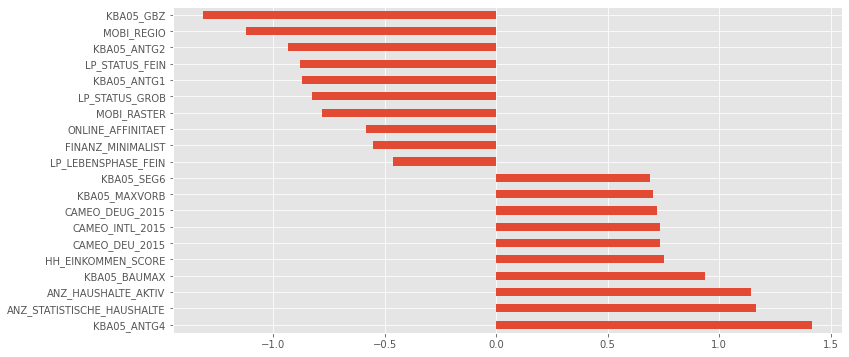

In [139]:
pca_inv_transform_plot(azdias_v2, km, 12)

In [154]:
pca_inv_transform_list(azdias_v2, km, 12)

KBA05_ANTG4                   1.415861
ANZ_STATISTISCHE_HAUSHALTE    1.166966
ANZ_HAUSHALTE_AKTIV           1.143049
KBA05_BAUMAX                  0.936360
HH_EINKOMMEN_SCORE            0.753580
CAMEO_DEU_2015                0.736738
CAMEO_INTL_2015               0.734618
CAMEO_DEUG_2015               0.721270
KBA05_MAXVORB                 0.704223
KBA05_SEG6                    0.689051
LP_LEBENSPHASE_FEIN          -0.459966
FINANZ_MINIMALIST            -0.550751
ONLINE_AFFINITAET            -0.581049
MOBI_RASTER                  -0.779661
LP_STATUS_GROB               -0.826315
KBA05_ANTG1                  -0.868483
LP_STATUS_FEIN               -0.877063
KBA05_ANTG2                  -0.932602
MOBI_REGIO                   -1.121129
KBA05_GBZ                    -1.313253
Name: feat_vals, dtype: float64

In [184]:
positive_features = ['KBA05_ANTG4','ANZ_STATISTISCHE_HAUSHALTE','ANZ_HAUSHALTE_AKTIV','KBA05_BAUMAX','HH_EINKOMMEN_SCORE',
                     'CAMEO_DEU_2015','CAMEO_INTL_2015','CAMEO_DEUG_2015','KBA05_MAXVORB','KBA05_SEG6']

negative_features = ['KBA05_GBZ','MOBI_REGIO','KBA05_ANTG2','LP_STATUS_FEIN','KBA05_ANTG1','LP_STATUS_GROB','MOBI_RASTER',
                     'ONLINE_AFFINITAET','FINANZ_MINIMALIST','LP_LEBENSPHASE_FEIN']

In [161]:
azdias_clusters = pd.concat([azdias_km, azdias_v2], axis=1)
azdias_positives_12 = azdias_clusters[positive_features][azdias_clusters.cluster==12]
azdias_positives_12.head()

,KBA05_ANTG4,ANZ_STATISTISCHE_HAUSHALTE,ANZ_HAUSHALTE_AKTIV,KBA05_BAUMAX,HH_EINKOMMEN_SCORE,CAMEO_DEU_2015,CAMEO_INTL_2015,CAMEO_DEUG_2015,KBA05_MAXVORB,KBA05_SEG6
28,0.0,11.0,13.0,3.0,5.0,31,41.0,7.0,3.0,0.0
45,2.0,12.0,10.0,4.0,5.0,31,41.0,7.0,3.0,0.0
50,0.0,5.0,6.0,3.0,6.0,40,52.0,9.0,2.0,0.0
56,2.0,22.0,25.0,5.0,5.0,37,41.0,8.0,3.0,0.0
57,1.0,36.0,36.0,0.0,6.0,28,35.0,6.0,9.0,9.0


In [185]:
azdias_negatives_12 = azdias_clusters[negative_features][azdias_clusters.cluster==12]
azdias_negatives_12.head()

,KBA05_GBZ,MOBI_REGIO,KBA05_ANTG2,LP_STATUS_FEIN,KBA05_ANTG1,LP_STATUS_GROB,MOBI_RASTER,ONLINE_AFFINITAET,FINANZ_MINIMALIST,LP_LEBENSPHASE_FEIN
28,3.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,2,5.0
45,1.0,2.0,0.0,2.0,0.0,1.0,1.0,3.0,1,29.0
50,2.0,2.0,0.0,2.0,0.0,1.0,1.0,2.0,1,0.0
56,1.0,1.0,0.0,4.0,0.0,2.0,1.0,2.0,2,22.0
57,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2,6.0


### Cluster 12: Negative Features

MOBI_REGIO: moving patterns
1: very high mobility
2: high mobility


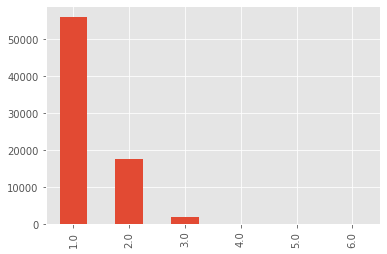

In [189]:
print("MOBI_REGIO: moving patterns")
print("1: very high mobility")
print("2: high mobility")
azdias_negatives_12.MOBI_REGIO.value_counts().plot.bar();

KBA05_ANTG2: number of 3-5 family houses in the cell
0: no 3-5 family homes


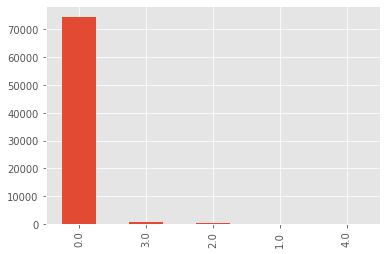

In [191]:
print("KBA05_ANTG2: number of 3-5 family houses in the cell")
print("0: no 3-5 family homes")
azdias_negatives_12.KBA05_ANTG2.value_counts().plot.bar();

LP_STATUS_FEIN: social status fine
1: typical low-income earners
2: orientationseeking low-income earners
3: aspiring low-income earners 


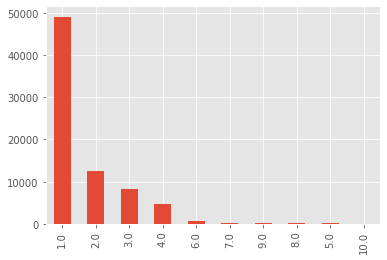

In [193]:
print("LP_STATUS_FEIN: social status fine")
print("1: typical low-income earners")
print("2: orientationseeking low-income earners")
print("3: aspiring low-income earners ")
azdias_negatives_12.LP_STATUS_FEIN.value_counts().plot.bar();

KBA05_ANTG1: number of 1-2 family houses in the cell
0: no 1-2 family homes


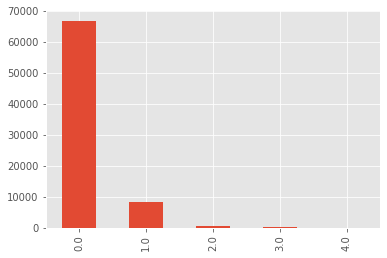

In [200]:
print("KBA05_ANTG1: number of 1-2 family houses in the cell")
print("0: no 1-2 family homes")
azdias_negatives_12.KBA05_ANTG1.value_counts().plot.bar();

LP_STATUS_GROB: social status rough
1 & 2: low-income earners


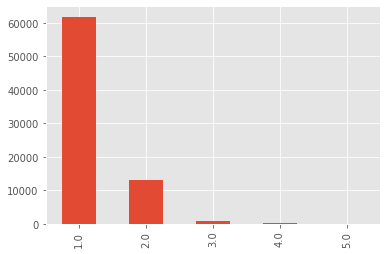

In [201]:
print("LP_STATUS_GROB: social status rough")
print("1 & 2: low-income earners")
azdias_negatives_12.LP_STATUS_GROB.value_counts().plot.bar();

ONLINE_AFFINITAET: online affinity
1: low, 0: None, 2: middle


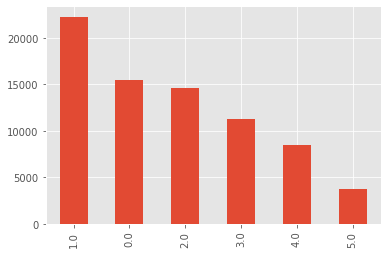

In [202]:
print("ONLINE_AFFINITAET: online affinity")
print("1: low, 0: None, 2: middle")
azdias_negatives_12.ONLINE_AFFINITAET.value_counts().plot.bar();

FINANZ_MINIMALIST: financial typology: low financial interest
2: high
3: average
1: very high


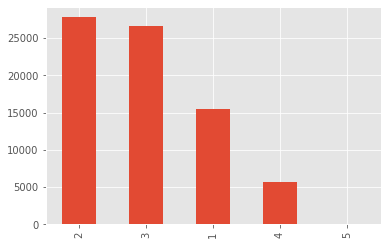

In [204]:
print("FINANZ_MINIMALIST: financial typology: low financial interest")
print("2: high")
print("3: average")
print("1: very high")
azdias_negatives_12.FINANZ_MINIMALIST.value_counts().plot.bar();

LP_LEBENSPHASE_FEIN: lifestage fine
6: single low-income earners at retirement age 
5: single low-income earners of advanced age
1: single low-income earners of younger age
2: single low-income earners of middle age
31: low-income earners of higher age from mulitperson households


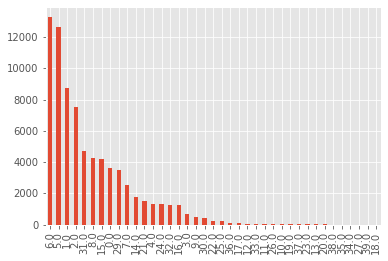

In [205]:
print("LP_LEBENSPHASE_FEIN: lifestage fine")
print("6: single low-income earners at retirement age ")
print("5: single low-income earners of advanced age")
print("1: single low-income earners of younger age")
print("2: single low-income earners of middle age")
print("31: low-income earners of higher age from mulitperson households")
azdias_negatives_12.LP_LEBENSPHASE_FEIN.value_counts().plot.bar();

### Cluster 12: Positive Features

KBA05_ANTG4: number of >10 family houses in the cell
2: high share of >10 family homes


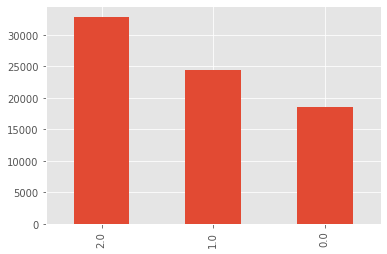

In [178]:
print("KBA05_ANTG4: number of >10 family houses in the cell")
print("2: high share of >10 family homes")
azdias_positives_12.KBA05_ANTG4.value_counts().plot.bar();

KBA05_BAUMAX: most common building-type within the cell
5: mainly business buildings in the microcell


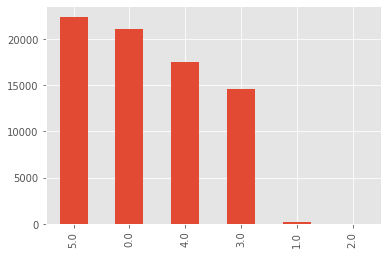

In [179]:
print("KBA05_BAUMAX: most common building-type within the cell")
print("5: mainly business buildings in the microcell")
azdias_positives_12.KBA05_BAUMAX.value_counts().plot.bar();

HH_EINKOMMEN_SCORE: estimated household net income
6: very low income


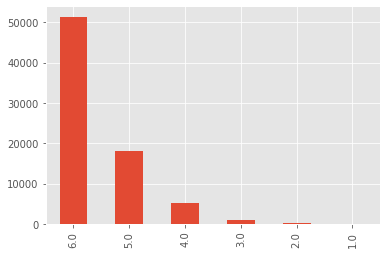

In [170]:
print("HH_EINKOMMEN_SCORE: estimated household net income")
print("6: very low income")
azdias_positives_12.HH_EINKOMMEN_SCORE.value_counts().plot.bar();

CAMEO classification 2015 - detailled classification
36: 8A Multi-Cultural


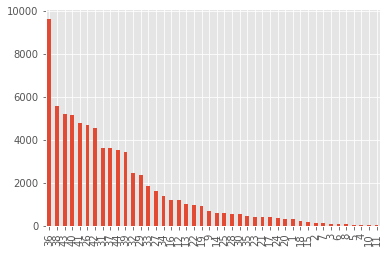

In [172]:
print("CAMEO classification 2015 - detailled classification")
print("36: 8A Multi-Cultural")
azdias_positives_12.CAMEO_DEU_2015.value_counts().plot.bar();

CAMEO classification 2015 - Uppergroup
9: urban working class
8: working class


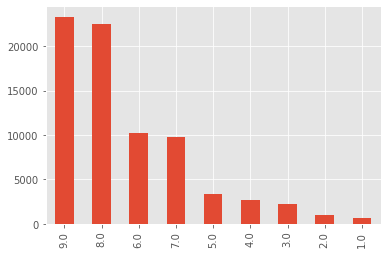

In [174]:
print("CAMEO classification 2015 - Uppergroup")
print("9: urban working class")
print("8: working class")
azdias_positives_12.CAMEO_DEUG_2015.value_counts().plot.bar();

KBA05_SEG6: share of upper class cars (BMW 7er etc.) in the microcell
0: None


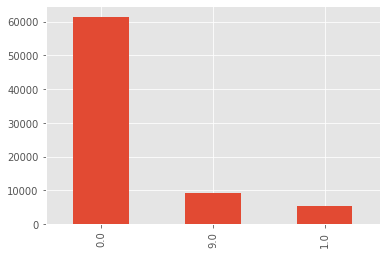

In [177]:
print("KBA05_SEG6: share of upper class cars (BMW 7er etc.) in the microcell")
print("0: None")
azdias_positives_12.KBA05_SEG6.value_counts().plot.bar();

### Insights: Customers of Cluster 12 
* For the mail-order company, 26% of the customers fell into cluster 12 and these customers are well represented. In another words, for every 4 customers, one of them falls into this cluster. There are other clusters as well, but cluster 12 was much greater than the general population's cluster 12. 
* This representation required a closer look. In close examination, the customers of cluster 12 are:
    * mostly low-income earners
    * not very verse with the online world
    * mostly are working class folks
    * mostly are in their advanced age
    * many have multi-cultural backgrounds
    * many have low financial interests
    * doesn't drive expensive cars

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [216]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [217]:
mailout_train.shape

(42962, 367)

In [218]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

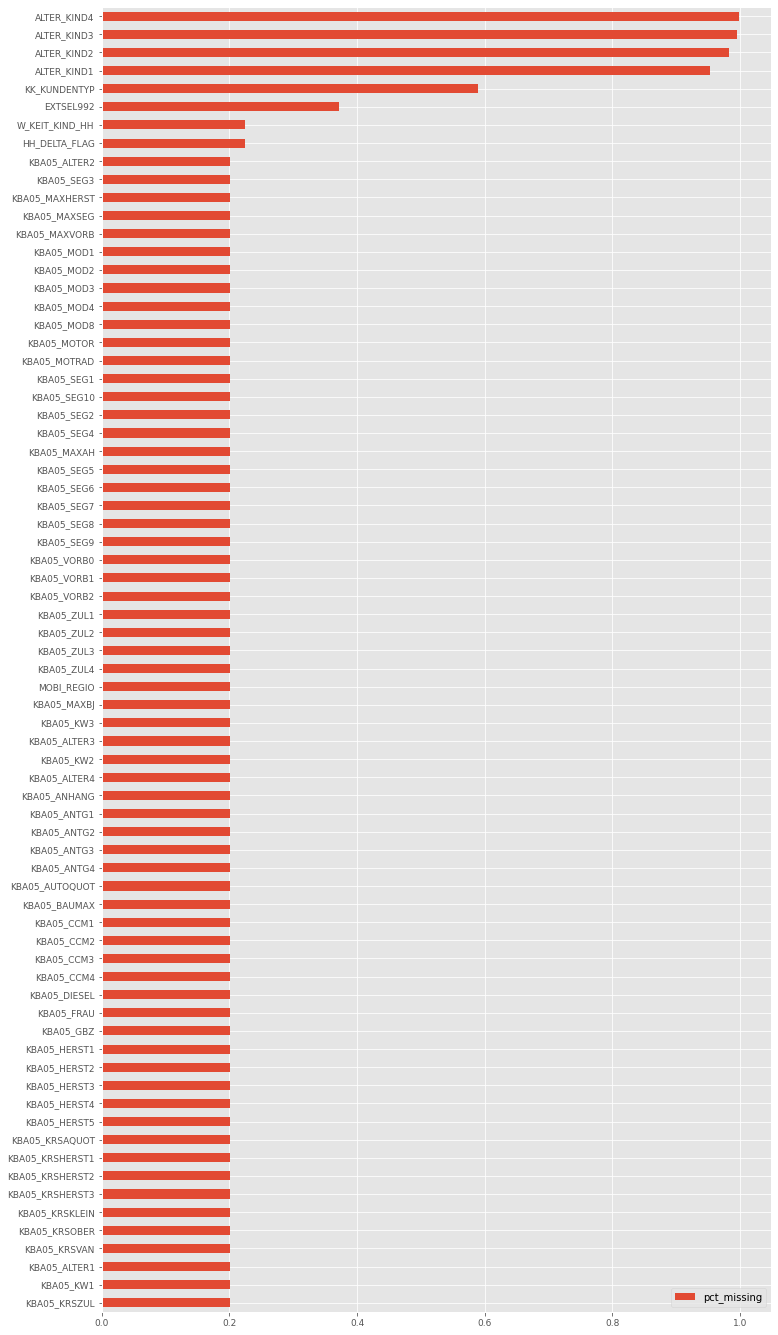

In [26]:
# features missing values more than 20%
mailout_train_missing = pd.DataFrame(mailout_train.isnull().mean(), columns=['pct_missing'])
mailout_train_missing[mailout_train_missing.pct_missing > 0.20].sort_values(
    by=['pct_missing'], ascending=False).plot.barh(figsize=(12, 24), fontsize=9).invert_yaxis()

In [27]:
# delete all features with missing values over 40%
del_vars = mailout_train_missing[mailout_train_missing.pct_missing > 0.4].index.tolist()
mailout_train.drop(columns=del_vars, inplace=True)

In [28]:
# delete ambiguous features
ambig_vars = ['STRUKTURTYP','GEMEINDETYP','ARBEIT','RELAT_AB','ANZ_HH_TITEL',
              'KONSUMZELLE','FIRMENDICHTE','AGER_TYP','TITEL_KZ','GEBURTSJAHR', 
              'EINGEFUEGT_AM','VERDICHTUNGSRAUM','D19_LETZTER_KAUF_BRANCHE', 'LNR']
mailout_train.drop(columns=ambig_vars, inplace=True)

In [29]:
pd.DataFrame({'colname': mailout_train.columns, 'dtype': mailout_train.dtypes.values}).dtype.value_counts()

float64    253
int64       91
object       4
Name: dtype, dtype: int64

In [30]:
mailout_train_dtypes = pd.DataFrame({'colname': mailout_train.columns, 'dtype': mailout_train.dtypes.values})
mailout_train_dtypes[mailout_train_dtypes.dtype=='object']

,colname,dtype
9,CAMEO_DEU_2015,object
10,CAMEO_DEUG_2015,object
11,CAMEO_INTL_2015,object
302,OST_WEST_KZ,object


In [31]:
# create dataframe with missing vars
mailout_train_na = pd.DataFrame(mailout_train.isnull().mean(), columns=['pct_missing'])
vars_with_na = mailout_train_na[mailout_train_na.pct_missing > 0].index.tolist()
df_mailout_train_vars_with_na = mailout_train[vars_with_na]

In [32]:
# create categorical and continuous feature numpy arrays; sklearn transformers require numpy arrays vs lists
vars_numeric = np.array(['KBA13_ANZAHL_PKW'])
vars_categoric = np.setdiff1d(vars_with_na, vars_numeric)

In [33]:
from sklearn.compose import ColumnTransformer

# preprocessing step: different procedures on different features
preprocessor = ColumnTransformer(transformers=[
    ('numeric_imputer', SimpleImputer(strategy='mean'), vars_numeric),
    ('categoric_imputer', SimpleImputer(strategy='most_frequent'), vars_categoric)
])

In [34]:
# now we fit the preprocessor
preprocessor.fit(df_mailout_train_vars_with_na)

ColumnTransformer(transformers=[('numeric_imputer', SimpleImputer(),
                                 array(['KBA13_ANZAHL_PKW'], dtype='<U16')),
                                ('categoric_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ALTER_HH',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'BALLRAUM',
       'CAMEO_DEUG_2015', 'CAMEO...
       'ONLINE_AFFINITAET', 'ORTSGR_KLS9', 'OST_WEST_KZ', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX',
       'PLZ8_GBZ', 'PLZ8_HHZ', 'REGIOTYP', 'RETOURTYP_BK_S',
       'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'RT_UEBERGROESSE', 'SOHO_KZ',
       'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VHA', 'VHN',
       'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'WOHNDAUER_2008', 'WOHNLAGE',
       'W_KEIT_KIND_HH'], dtype='<U27'))])

In [67]:
# impute data
mailout_train_imputed_only = preprocessor.transform(df_mailout_train_vars_with_na)

In [68]:
# examine the output
mailout_train_imputed_only = pd.DataFrame(mailout_train_imputed_only, 
                                          columns=list(vars_numeric) + list(vars_categoric))

In [69]:
# combine dataframes
mailout_train_v2 = generate_full_dataframe(mailout_train, mailout_train_imputed_only)
mailout_train_v2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSICHERUNGEN,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GREEN_AVANTGARDE,HEALTH_TYP,KOMBIALTER,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RESPONSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,KBA13_ANZAHL_PKW,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_LOTTO,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,GEBAEUDETYP,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,

In [70]:
pickle.dump(mailout_train_v2, open("serialized_objects/mailout_train_v2.p", "wb"))

In [208]:
mailout_train_v2 = pickle.load(open("serialized_objects/mailout_train_v2.p", "rb"))

### Model Selection

In [74]:
# standardize train data 
y_mailout_train = mailout_train_v2.RESPONSE
mailout_train_v2.drop(columns=['RESPONSE'], inplace=True)
X_mailout_train_scaled = StandardScaler().fit_transform(mailout_train_v2)
X_mailout_train_scaled = pd.DataFrame(X_mailout_train_scaled, columns=mailout_train_v2.columns).dropna()

In [79]:
# response skewness
y_mailout_train.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [82]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import Perceptron
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC, LinearSVC
# from sklearn.naive_bayes import GaussianNB

# from imblearn.pipeline import Pipeline as imbl_pipeline
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.model_selection import cross_val_score

# paramters: models (dict), X_train (dataframe, array), y_train (dataframe, array)
def output_model_stats(models, X_train, y_train):
    over = RandomOverSampler(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5) 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    
    index_names, model_scores = [], []
    for mname, minst in models.items():
        # append model name
        index_names.append(mname)
        
        # create pipeline with scaler and model instantiation steps
        steps = [('o', over), ('u', under), ('m', minst)]
        pipeline = imbl_pipeline(steps=steps)
        
        # evaluate pipeline
        scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        score = np.mean(scores)
        model_scores.append(score)
        
    output = pd.DataFrame({'score': model_scores}, index=index_names)
    return output

In [83]:
# random_state=0 for reproducibility
models = {'LogisticRegression': LogisticRegression(random_state=0),
          'SupportVectorMachines': SVC(random_state=0),
          'RandomForest': RandomForestClassifier(random_state=0),
          'KNN': KNeighborsClassifier(n_neighbors=5),
          'GaussianNaiveBayes': GaussianNB(),
          'Perceptron': Perceptron(random_state=0),
          'LinearSVC': LinearSVC(dual=False, random_state=0),
          'StochasticGradientDescent': SGDClassifier(random_state=0),
          'DecisionTree': DecisionTreeClassifier(random_state=0)}

model_outputs = output_model_stats(models, X_mailout_train_scaled, y_mailout_train)
model_outputs

,score
LogisticRegression,0.651277
SupportVectorMachines,0.625825
RandomForest,0.662905
KNN,0.521531
GaussianNaiveBayes,0.624950
Perceptron,0.603624
LinearSVC,0.653432
StochasticGradientDescent,0.630802
DecisionTree,0.523993


**Based on this initial run, random forest looks the best using the ROC AUC as the model performance metric. As a result, random forest algorithm will be used going forward to complete this exercise.**

### Feature Importance

In [86]:
def rf_feature_ranking(n, feature_importance_scores, X_train):
    """
    n (parameter 1): an integer; number of features in X_train
    feature_importance_scores (parameter 2): numpy ndarray from sklearn.ensemble.RandomForestClassifier.feature_importances_
    """
    
    feature_importances = {}
    for idx in range(n):
        key = X_train.columns[idx]
        val = feature_importance_scores[idx]
        feature_importances[key] = val

    df_feature_importances = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
    df_sorted = df_feature_importances.sort_values('importance', ascending=False)
    
    return df_sorted

In [91]:
# define oversampling and undersampling objects
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5) 

# create pipeline 
steps = [('o', over), ('u', under), ('m', RandomForestClassifier(random_state=0))]
rf_pipeline = imbl_pipeline(steps=steps)

# fit model
rf_pipeline.fit(X_mailout_train_scaled, y_mailout_train)

Pipeline(steps=[('o', RandomOverSampler(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.5)),
                ('m', RandomForestClassifier(random_state=0))])

In [95]:
rf_pipeline[2]

RandomForestClassifier(random_state=0)

In [96]:
# assess feature importance
n = len(X_mailout_train_scaled.columns)
importance_scores = rf_pipeline[2].feature_importances_
rf_feature_ranking(n, importance_scores, X_mailout_train_scaled)

,importance
D19_SOZIALES,0.051151
D19_KONSUMTYP_MAX,0.022701
D19_KONSUMTYP,0.016768
RT_SCHNAEPPCHEN,0.012598
LP_LEBENSPHASE_FEIN,0.009476
KBA13_ANZAHL_PKW,0.008778
GFK_URLAUBERTYP,0.008538
CAMEO_DEU_2015,0.008115
EXTSEL992,0.006790
ALTER_HH,0.006445


In [97]:
rf_base.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [100]:
pickle.dump(rf_pipeline, open("serialized_objects/rf_pipeline_fitted.p", "wb"))

### RandomizedSearchCV: Random Forest Classifier

In [5]:
# load fitted model and train v2 data
rf_pipeline = pickle.load(open("serialized_objects/rf_pipeline_fitted.p", "rb"))
mailout_train_v2 = pickle.load(open("serialized_objects/mailout_train_v2.p", "rb"))

# standardize train data 
y_mailout_train = mailout_train_v2.RESPONSE
mailout_train_v2.drop(columns=['RESPONSE'], inplace=True)
X_mailout_train_scaled = StandardScaler().fit_transform(mailout_train_v2)
X_mailout_train_scaled = pd.DataFrame(X_mailout_train_scaled, columns=mailout_train_v2.columns).dropna()

In [8]:
%%time 

# param_distributions with m__* to identify random forest label in the pipeline
param_grid = {'m__criterion': ['gini', 'entropy'],
              'm__n_estimators': [100, 300, 500, 800, 1000, 1200, 1400],
              'm__max_features': ['auto', 'log2'],
              'm__max_depth': [3, 5, 7, 9, 15, 25, 30],
              'm__min_samples_split': [2, 3, 4, 5, 7, 10, 15],
              'm__min_samples_leaf': [1, 2, 5, 10, 12, 14]}

# randomized search
rf_search = RandomizedSearchCV(estimator=rf_pipeline, 
                               param_distributions=param_grid, 
                               n_iter=100, 
                               cv=5, 
                               verbose=3, 
                               random_state=0, 
                               n_jobs=-1)

# fit model
rf_search.fit(X_mailout_train_scaled, y_mailout_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 16.1 s, sys: 846 ms, total: 17 s
Wall time: 19min 24s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('o',
                                              RandomOverSampler(sampling_strategy=0.1)),
                                             ('u',
                                              RandomUnderSampler(sampling_strategy=0.5)),
                                             ('m',
                                              RandomForestClassifier(random_state=0))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'m__criterion': ['gini', 'entropy'],
                                        'm__max_depth': [3, 5, 7, 9, 15, 25,
                                                         30],
                                        'm__max_features': ['auto', 'log2'],
                                        'm__min_samples_leaf': [1, 2, 5, 10, 12,
                                                                14],
                                        'm__min_samples_split': [2, 3

In [10]:
# show tuned hyperparameter values
rf_search.best_params_

{'m__n_estimators': 800,
 'm__min_samples_split': 7,
 'm__min_samples_leaf': 12,
 'm__max_features': 'log2',
 'm__max_depth': 9,
 'm__criterion': 'gini'}

In [11]:
# define our optimal random forest model
randomized_search_rf = rf_search.best_estimator_

# cross validation score
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

rand_search_auc_scores = cross_val_score(randomized_search_rf, 
                                         X_mailout_train_scaled, 
                                         y_mailout_train, 
                                         cv=cv, 
                                         scoring='roc_auc', 
                                         n_jobs=-1)

print("roc_auc:", rand_search_auc_scores.mean())
print("standard deviation:", rand_search_auc_scores.std())

roc_auc: 0.7016553360191125
standard deviation: 0.0336394453440789


**The new ROC AUC of 0.70165 is an improvement from the initial number of 0.662905. Let's see we can further improve this number by running GridSearchCV.**

In [14]:
pickle.dump(randomized_search_rf, open("serialized_objects/randomized_search_rf.p", "wb"))

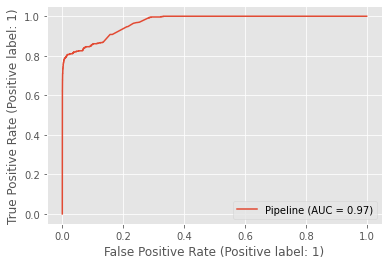

In [44]:
# the model is overfitting in this ROC curve. 
from sklearn import metrics
metrics.plot_roc_curve(randomized_search_rf, X_mailout_train_scaled, y_mailout_train) 
plt.show()

### GridSearchCV: Random Forest Classifier

In [16]:
%%time

# define gridsearch parameters
gs_param_grid = {'m__criterion': ['gini', 'entropy'],
                 'm__n_estimators': [700, 800, 900],
                 'm__max_features': ['auto', 'log2'],
                 'm__max_depth': [8, 9, 10],
                 'm__min_samples_split': [6, 7, 8],
                 'm__min_samples_leaf': [11, 12, 13]}

# instantiate gridsearchcv class
rfgs = GridSearchCV(estimator=rf_pipeline,
                    param_grid=gs_param_grid,
                    cv=5,
                    verbose=5,
                    n_jobs=-1)

# fit model
rfgs.fit(X_mailout_train_scaled, y_mailout_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
CPU times: user 32.3 s, sys: 1.65 s, total: 33.9 s
Wall time: 1h 9min 38s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('o',
                                        RandomOverSampler(sampling_strategy=0.1)),
                                       ('u',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('m',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'m__criterion': ['gini', 'entropy'],
                         'm__max_depth': [8, 9, 10],
                         'm__max_features': ['auto', 'log2'],
                         'm__min_samples_leaf': [11, 12, 13],
                         'm__min_samples_split': [6, 7, 8],
                         'm__n_estimators': [700, 800, 900]},
             verbose=5)

In [17]:
# output best hyperparameters
rfgs.best_params_

{'m__criterion': 'gini',
 'm__max_depth': 8,
 'm__max_features': 'log2',
 'm__min_samples_leaf': 11,
 'm__min_samples_split': 7,
 'm__n_estimators': 900}

In [18]:
# define our optimal random forest model
grid_search_rf = rfgs.best_estimator_

# cross validation score
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

grid_search_auc_scores = cross_val_score(grid_search_rf, 
                                         X_mailout_train_scaled, 
                                         y_mailout_train, 
                                         cv=cv, 
                                         scoring='roc_auc', 
                                         n_jobs=-1)

print("roc_auc:", grid_search_auc_scores.mean())
print("standard deviation:", grid_search_auc_scores.std())

roc_auc: 0.7012645963955706
standard deviation: 0.033465838517556565


**The GridSearchCV procedure did not generate a better ROC AUC metric versus the RandomizedSearchCV. For the Kaggle competition, I'll be using the randomized search fitted model to make the predictions and submit.**

In [19]:
pickle.dump(grid_search_rf, open("serialized_objects/grid_search_rf.p", "wb"))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [70]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [71]:
mailout_test.shape

(42833, 366)

In [72]:
# separate LNR to be merged with test response output later 
X_mailout_test_LNR = mailout_test.LNR

In [73]:
def generate_full_dataframe(df_original, df_imputed):
    df_original = df_original.copy()
    df_imputed = df_imputed.copy()
    
    # azdias: combine imputed columns and the diff columns 
    diff_features_not_imputed = np.setdiff1d(df_original.columns, df_imputed.columns)
    df_features_with_no_na = df_original[diff_features_not_imputed]

    # combine the dataframe and create fully imputed / no NaN dataframe
    df_features_with_no_na.reset_index(drop=True, inplace=True)
    df_imputed.reset_index(drop=True, inplace=True)

    dfv2 = pd.concat([df_features_with_no_na, df_imputed], axis=1)
    for var in ['pct_missing', 'num_missing']:
        try:
            dfv2.drop(columns=var, inplace=True)
        except:
            continue

    # encode string into binary 1 or 0
    dfv2['OST_WEST_KZ'] = dfv2['OST_WEST_KZ'].apply(lambda x: 1 if x=='W' else 0)

    # encode string labels in CAMEO_DEU_2015 into numeric labels using the encoding dictionary
    cameo_deu_2015_labels = sorted(dfv2['CAMEO_DEU_2015'].unique())
    CAMEO_DEU_2015_encoding = {val: key + 1 for key, val in enumerate(cameo_deu_2015_labels)}

    # change the string labels into numeric labels
    dfv2['CAMEO_DEU_2015'] = dfv2['CAMEO_DEU_2015'].map(CAMEO_DEU_2015_encoding)

    # replace X with numeric
    dfv2['CAMEO_DEUG_2015'] = dfv2['CAMEO_DEUG_2015'].apply(lambda x: -1 if x=='X' else x)

    # replace XX with numeric
    dfv2['CAMEO_INTL_2015'] = dfv2['CAMEO_INTL_2015'].apply(lambda x: -1 if x=='XX' else x)

    # change objects into floats
    for var, dtype in dict(dfv2.dtypes).items():
        if dtype == 'O':
            dfv2[var] = dfv2[var].apply(lambda x: float(str(x).replace(" ","")))
    
    return dfv2


def data_imputing(df):
    # features missing values more than 20%
    df_missing_v1 = pd.DataFrame(df.isnull().mean(), columns=['pct_missing'])

    # delete all features with missing values over 40%
    drop_vars = df_missing_v1[df_missing_v1.pct_missing > 0.4].index.tolist()
    df.drop(columns=drop_vars, inplace=True)

    # delete ambigious features
    ambig_vars = ['STRUKTURTYP','GEMEINDETYP','ARBEIT','RELAT_AB','ANZ_HH_TITEL',
                  'KONSUMZELLE','FIRMENDICHTE','AGER_TYP','TITEL_KZ','GEBURTSJAHR', 
                  'EINGEFUEGT_AM','VERDICHTUNGSRAUM','D19_LETZTER_KAUF_BRANCHE', 'LNR']
    
    for ambig_var in ambig_vars:
        try: 
            df.drop(columns=ambig_var, inplace=True)
        except:
            continue

    # create fit dataframe
    df_missing_v2 = pd.DataFrame(df.isnull().mean(), columns=['pct_missing'])
    vars_with_na = df_missing_v2[df_missing_v2.pct_missing > 0].index.tolist()
    df_vars_with_na = df[vars_with_na]

    # create categorical and continuous feature numpy arrays; sklearn transformers require numpy arrays vs lists
    vars_numeric = np.array(['KBA13_ANZAHL_PKW'])
    vars_categoric = np.setdiff1d(vars_with_na, vars_numeric)

    # impute data with fitted preprocessor object from previous steps with training data
    # the preprocessor.fit step is completed in the mailout training section
    df_imputed_only = preprocessor.transform(df_vars_with_na)

    # examine the output
    df_imputed_only = pd.DataFrame(df_imputed_only, columns=list(vars_numeric) + list(vars_categoric))

    # combine dataframes
    df_v2 = generate_full_dataframe(df, df_imputed_only)

    # split into X and y, and scale X 
    try:
        y = df_v2.RESPONSE
        df_v2.drop(columns=['RESPONSE'], inplace=True)
    except:
        y = 0
    
    X = StandardScaler().fit_transform(df_v2)
    X = pd.DataFrame(X, columns=df_v2.columns).dropna()

    return X, y

In [74]:
X_mailout_test, y_mailout_test = data_imputing(mailout_test)

In [75]:
X_mailout_test.shape

(42833, 347)

In [76]:
# use oversampled, undersampled, random forest tuned using randomized search cv model to make predictions
y_mailout_test_pred = randomized_search_rf.predict(X_mailout_test)

In [77]:
response_output = pd.DataFrame({'LNR': X_mailout_test_LNR, 'RESPONSE': y_mailout_test_pred})
response_output.shape

(42833, 2)

In [81]:
response_output.to_csv('response_output.csv', index=False)